# **Import Necessary Libraries**

In [1]:
import cv2
import numpy as np
from PIL import Image
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops 
import os 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# **Preprocess the Image**

In [2]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (512, 512))  # Resize for consistency
    return image

# **Feature Extraction**


In [3]:
#LBP feature extraction
def lbp_texture_analysis(image, radius=1, num_points=8):
    """
    Perform texture analysis on an image using Local Binary Patterns (LBP).
    :param image: Grayscale image as a numpy array.
    :param radius: Radius of the circle (default is 1).
    :param num_points: Number of points considered around the circle (default is 8).
    :return: LBP image and the histogram of LBP patterns.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute LBP
    lbp = local_binary_pattern(gray_image, num_points, radius, method='uniform')
    
    # Compute histogram of LBP
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    
    return lbp, lbp_hist


In [4]:
# GLCM feature extraction 
def compute_glcm(image):
    # Define the GLCM parameters
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    
    distances = [1]  # Pixel pair distance
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Directions to consider
    levels = 256  # Number of gray levels in the image

    # Compute GLCM
    glcm = graycomatrix(gray_image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    
    # Step 3: Extract features
    contrast = graycoprops(glcm, 'contrast').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    
    # Concatenate features
    features = np.hstack([contrast, correlation, energy, homogeneity])
    return features

In [5]:
#Color consistency feature extraction 

#Convert Image to YUV Color Space and Analyze Color Channels
def analyze_color_consistency(image):
    # Convert the image to YUV color space
    yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV) 
    
    # Extract the U and V channels (chromatic components)
    u_channel = yuv_image[:, :, 1]
    v_channel = yuv_image[:, :, 2]
    
    # Calculate the mean and standard deviation of U and V channels
    u_mean, u_std = cv2.meanStdDev(u_channel)
    v_mean, v_std = cv2.meanStdDev(v_channel)
    
    # Calculate color consistency features
    color_consistency = np.array([u_mean[0][0], u_std[0][0], v_mean[0][0], v_std[0][0]])
    return color_consistency

In [6]:
# Extracting combined feature 

def extract_feature(image_path):
    
    image = preprocess_image(image_path)
    
    _, lbp_hist= lbp_texture_analysis(image)
    glcm_features = compute_glcm(image)
    consistency=analyze_color_consistency(image)
    
    combined_features = np.hstack([lbp_hist, glcm_features,consistency])
    return combined_features

# **Load Dataset**

In [7]:
folder_path = 'C:/Users/sadik/OneDrive/Desktop/Liveness detection/dataset'

In [8]:
def load_dataset(folder_path, label):
    feature_list = []
    labels=[]
    
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        features = extract_feature(image_path)
        if features is not None:
            feature_list.append(features)
            labels.append(label)
    return np.array(feature_list), np.array(labels)

In [9]:
live_train_path = 'C:/Users/sadik/OneDrive/Desktop/Liveness detection/dataset/Live/Train'
live_test_path = 'C:/Users/sadik/OneDrive/Desktop/Liveness detection/dataset/Live/Test'
spoof_train_path = 'C:/Users/sadik/OneDrive/Desktop/Liveness detection/dataset/Spoof/Train'
spoof_test_path = 'C:/Users/sadik/OneDrive/Desktop/Liveness detection/dataset/Spoof/Test'

In [10]:
#Extract feature for both live and spoof dataset 
X_live_train,y_live_train = load_dataset(live_train_path, label=1)
X_spoof_train, y_spoof_train = load_dataset(spoof_train_path,label=0)
X_live_test, y_live_test = load_dataset(live_test_path,label=1)
X_spoof_test, y_spoof_test = load_dataset(spoof_test_path,label=0)

In [11]:
# Combine the live and spoof training data
X_train = np.vstack((X_live_train, X_spoof_train))
y_train = np.concatenate((y_live_train, y_spoof_train), axis=0)
# Combine the live and spoof testing data
X_test = np.vstack((X_live_test, X_spoof_test))
y_test = np.concatenate((y_live_test, y_spoof_test), axis=0)

# **Feature Selection and Saving**

In [12]:
#Scale the features using StandardScaler
ss=StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled=ss.transform(X_test)

In [57]:
selected_indices=[2, 4, 6, 9, 10, 11, 12, 13, 15, 16, 19, 25, 27, 28, 29]

# Extract features based on these indices
X_train_selected = X_train_scaled[:, selected_indices]
X_test_selected = X_test_scaled[:, selected_indices]

# Save the selected features to .npy files
np.save('selected_train_features.npy', X_train_selected)
np.save('selected_test_features.npy', X_test_selected)

In [32]:
X_train_selected.shape

(497, 15)

In [33]:
#Mean of each features
x = 0
while (x < 497):
    arr1 = np.array(X_train_selected[x])
    arr11 = np.mean(arr1)
    print(f"Arithmetic Mean of feature {x} :", arr11)
    x += 1 


Arithmetic Mean of feature [0] : -0.4791661051960389
Arithmetic Mean of feature [1] : -0.4625694029362883
Arithmetic Mean of feature [2] : -0.4379101461830138
Arithmetic Mean of feature [3] : -0.4516869525804107
Arithmetic Mean of feature [4] : -0.4234830528808594
Arithmetic Mean of feature [5] : -0.40081832588276184
Arithmetic Mean of feature [6] : -0.4053949442908066
Arithmetic Mean of feature [7] : -0.493270943163009
Arithmetic Mean of feature [8] : -0.4848833605102788
Arithmetic Mean of feature [9] : -0.48307311751939325
Arithmetic Mean of feature [10] : -0.5151124813390895
Arithmetic Mean of feature [11] : -0.49890056907611446
Arithmetic Mean of feature [12] : -0.5028098982658785
Arithmetic Mean of feature [13] : -0.43817299694615836
Arithmetic Mean of feature [14] : -0.45964689268142467
Arithmetic Mean of feature [15] : -0.4709308532680637
Arithmetic Mean of feature [16] : -0.46990796084933234
Arithmetic Mean of feature [17] : 0.12498916594443008
Arithmetic Mean of feature [18] :

In [34]:
#Pixel value 
 
def calculate_average_pixel_value(image):
    mean_pixel_value = np.mean(image)
    return mean_pixel_value

image_paths = []
for folder in [live_train_path, spoof_train_path]:
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):  
            image_paths.append(os.path.join(folder, filename))

# Calculate average pixel values
for idx, image_path in enumerate(image_paths):
    image = preprocess_image(image_path)
    average_pixel_value = calculate_average_pixel_value(image)
    print(f"Average pixel value for image {idx + 1}: {average_pixel_value}")


Average pixel value for image 1: 123.09177780151367
Average pixel value for image 2: 187.65487798055014
Average pixel value for image 3: 147.46598052978516
Average pixel value for image 4: 149.9573237101237
Average pixel value for image 5: 145.24126942952475
Average pixel value for image 6: 132.21796035766602
Average pixel value for image 7: 143.0890630086263
Average pixel value for image 8: 161.35546112060547
Average pixel value for image 9: 167.81335830688477
Average pixel value for image 10: 163.15514373779297
Average pixel value for image 11: 171.39447784423828
Average pixel value for image 12: 168.96014277140299
Average pixel value for image 13: 173.03829701741537
Average pixel value for image 14: 168.52833557128906
Average pixel value for image 15: 173.4447479248047
Average pixel value for image 16: 178.21684900919595
Average pixel value for image 17: 181.6506436665853
Average pixel value for image 18: 145.60679372151694
Average pixel value for image 19: 118.14951451619466
Averag

In [59]:
print(X_test_selected.dtype)
print(X_test_selected[0])

float64
[-1.60612472  1.3483725  -1.65735312 -1.54883469 -0.64821389 -0.62372749
 -0.5536357  -0.59521134  0.41113846  0.37407268 -0.14145756  1.10802428
  0.50928413  1.17151223  0.01478785]


# **Train using RandomForest** # 

True Positive: 58
False Negative: 2
False Positive: 0
True Negative: 60
Accuracy : 0.9833333333333333
Precision: 0.967741935483871
Recall: 1.0


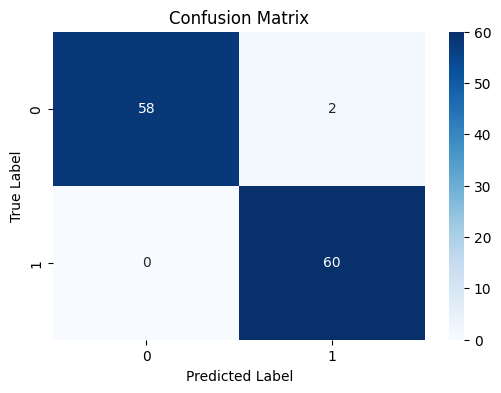

In [60]:
def run_randomForest(X_train_scaled, X_test_scaled, y_train, y_test):
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf.fit(X_train_scaled, y_train)
    return clf


clf = run_randomForest(X_train_selected, X_test_selected, y_train, y_test)

y_pred = clf.predict(X_test_selected)
# Determine the unique labels in y_test
unique_labels = np.unique(y_test)

# Generate the confusion matrix with the appropriate labels
conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_labels)

# Handle cases where unique_labels may not contain both 0 and 1
TP = conf_matrix[0][0] if 1 in unique_labels else 0
FN = conf_matrix[0][1] if 1 in unique_labels and len(unique_labels) > 1 else 0
FP = conf_matrix[1][0] if 0 in unique_labels and len(unique_labels) > 1 else 0
TN = conf_matrix[1][1] if 0 in unique_labels else 0

# Print the results
print("True Positive:", TP)
print("False Negative:", FN)
print("False Positive:", FP)
print("True Negative:", TN)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label=1) if 1 in unique_labels else 'N/A')
print("Recall:", recall_score(y_test, y_pred, pos_label=1) if 1 in unique_labels else 'N/A')

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [63]:
def predict(image):
    extract=extract_feature(image)
    extracted = extract.reshape(1, -1)
    scaled=ss.transform(extracted)
    selected=scaled[:,selected_indices]
    print(selected)
    np.save('individual.npy',selected)
    predicted=clf.predict(selected)
    print(predicted)
    return 'Live' if predicted == 1 else 'Spoof'
    
image='C:/Users/sadik/OneDrive/Desktop/Liveness detection/dataset/Spoof/12.jpg'

output=predict(image)
print(output)
    

[[-0.04994653 -0.98104625  0.16941447  0.92130191 -0.27654276 -0.28900538
  -0.26314491 -0.26888994  0.36208937  0.33545814 -0.26100677  0.77237054
  -0.59369999  4.00012997  2.21080241]]
[0]
Spoof



# **UI**

In [62]:
import gradio as gr
from PIL import Image

# Gradio Interface
UI = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="filepath"),
    outputs="text",
    title="Liveness Detection",
    description="Upload an image to predict whether it is live or spoof."
)

UI.launch()


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
